<a href="https://colab.research.google.com/github/snowysunny/Colaboratory/blob/master/xgboost%E7%AE%80%E5%8D%95%E5%BA%94%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [6]:
# 授权绑定Google Drive 这样就能将数据存储到Google Driver云端硬盘中，也可以从云端硬盘中获取到数据了
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110845 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Colab_Notebooks") 

In [0]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [11]:
test.iloc[:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
train.iloc[:2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [0]:
# 数据清洗
def clearn(titanic):
    # 使用中值填充NaN
    titanic["age"] = titanic["Age"].fillna(titanic["Age"].median())
    # 是否是小孩
    titanic["child"] = titanic["Age"].apply(lambda x: 1 if x < 15 else 0)
    
    titanic["sex"] = titanic["Sex"].apply(lambda x: 1 if x=="male" else 0)
    
    titanic["Embarked"] = titanic["Embarked"].fillna("S")
    def embark(Embark):
        if Embark == "S":
            return 1
        elif Embark == "C":
            return 2
        else:
            return 3
        
    titanic["embarked"] = titanic["Embarked"].apply(embark)
    
    titanic['family'] = titanic["SibSp"] + titanic["Parch"] + 1
    
    titanic["cabin"] = titanic["Cabin"].apply(lambda x: 0 if x=="N" else 1)
    
    def getname(Name):
        if "Mrs" in str(Name):
            return 2
        elif "Mr" in str(Name):
            return 1
        else:
            return 0
        
    titanic["name"] = titanic["Name"].apply(getname)
    
    titanic["fare"] = titanic["Fare"].fillna(titanic["Fare"].median())
    
    return titanic

In [0]:
train_data = clearn(train)
test_data = clearn(test)

In [22]:
train_data.iloc[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age,child,sex,embarked,family,cabin,name,fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,0,1,1,2,1,1,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,0,0,2,2,1,2,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,0,0,1,1,1,0,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,0,0,1,2,1,2,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,0,1,1,1,1,1,8.0500


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5b4e14208>]],
      dtype=object)

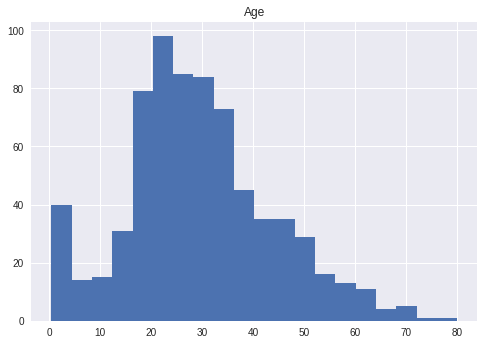

In [35]:
train_data.hist(column="Age",bins=20)

In [0]:
features = ["Pclass", "sex", "child", "family", "fare", "embarked", "cabin"]
clf = XGBClassifier(learning_rate=0.1, max_depth=2, silent=True, objective="binary:logistic")
param_test = {
    'n_estimators': [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50],
    'max_depth': [2, 3, 4, 5, 6, 7]
}


In [0]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_test, scoring="accuracy", cv=5)

In [25]:
grid_search.fit(train[features], train["Survived"])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50], 'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [29]:
grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50], 'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [0]:
predict_data = grid_search.predict(test[features])

In [28]:
predict_data

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [30]:
len(predict_data)

418

In [38]:
test_data.shape

(418, 19)